In [5]:
import inspect

if not hasattr(inspect, "getargspec"):
    from collections import namedtuple
    ArgSpec = namedtuple('ArgSpec', 'args varargs keywords defaults')

    def getargspec(func):
        return ArgSpec(*inspect.getfullargspec(func)[:4])

    inspect.getargspec = getargspec

In [2]:
import bz2, json
import pandas as pd
from tqdm import tqdm

data_path = "banki_responses.json.bz2"

def stream_json_array_objects(bz2path, max_items=None):
    with bz2.open(bz2path, "rt", encoding="utf-8") as f:
        buf = ""
        inside = False
        depth = 0
        obj_buf = ""
        count = 0
        for ch in f.read():
            if ch == "[":
                inside = True
                continue
            if not inside:
                continue
            obj_buf += ch
            if ch == "{":
                depth += 1
            elif ch == "}":
                depth -= 1
                if depth == 0:
                    try:
                        obj = json.loads(obj_buf.strip().rstrip(","))
                        yield obj
                        count += 1
                        if max_items and count >= max_items:
                            return
                    except:
                        pass
                    obj_buf = ""

In [3]:
# Читаем данные (ограничение для быстрого теста — max_items)
rows = []
for obj in tqdm(stream_json_array_objects(data_path, max_items=20000)):
    text = obj.get("text") or obj.get("message") or obj.get("review_text") or ""
    rating = obj.get("rating_grade")
    try:
        rating = int(rating)
    except:
        rating = None
    rows.append({
        "text": text,
        "rating": rating,
        "city": obj.get("city"),
        "bank": obj.get("bank")
    })

df = pd.DataFrame(rows)
df.head()

20000it [02:38, 126.16it/s] 


,text,rating,city,bank
0,"Доброго времени суток, читающим! 6 мая 2011 г....",1.0,г. ? видимо москва или новосибирск,None
1,30.05.2011 г. возникла необходимость положить ...,NaN,г. Екатеринбург,None
2,"На днях с супругой побывал в офисе ""На 1-ой Тв...",5.0,г. Москва,None
3,"Клиентом банка на данный момент не являюсь, но...",NaN,г. Екатеринбург,None
4,Я давний клиент этого банка. Самый первый кред...,5.0,г. москва,None


## 1. Анализ текстов

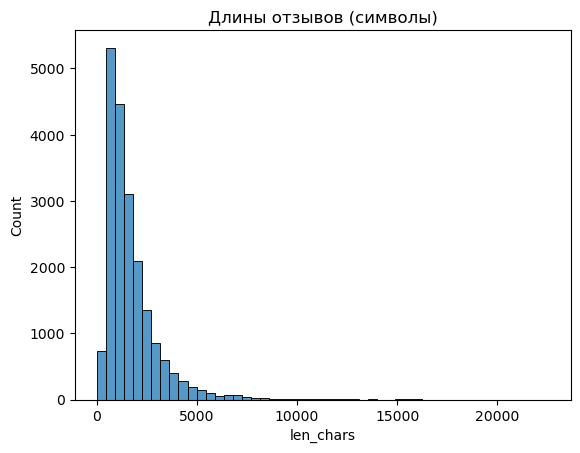

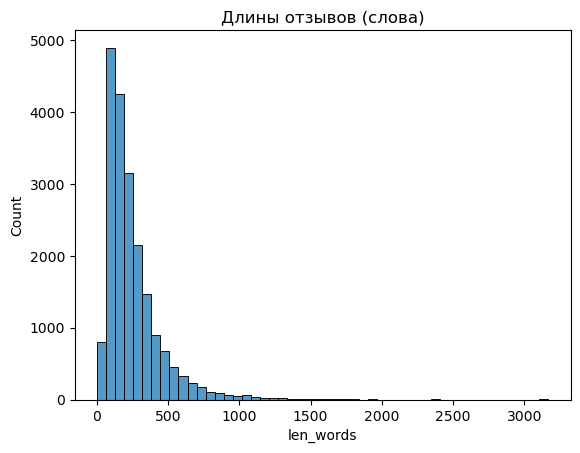

Топ-10 слов: [('в', 189077), ('и', 151669), ('не', 118302), ('на', 98455), ('что', 89424), ('я', 78982), ('с', 63842), ('по', 50275), ('мне', 42291), ('банка', 37717)]
Топ-10 без стоп-слов: [('банка', 37717), ('банк', 29918), ('это', 27592), ('деньги', 17669), ('карту', 14209), ('карты', 12951), ('очень', 11457), ('т', 10939), ('банке', 10694), ('кредит', 10317)]
Топ-10 лемм: [('банк', 606), ('карта', 293), ('деньга', 182), ('кредит', 180), ('это', 176), ('счёт', 154), ('который', 149), ('отделение', 135), ('день', 131), ('мой', 127)]


In [6]:
import re, nltk, pymorphy2, matplotlib.pyplot as plt, seaborn as sns
from collections import Counter
from nltk.corpus import stopwords

ru_stop = set(stopwords.words("russian"))
morph = pymorphy2.MorphAnalyzer()

def tokenize(text):
    return re.findall(r"[а-яА-ЯёЁ]+", text.lower())

df['tokens'] = df['text'].fillna('').map(tokenize)
df['len_chars'] = df['text'].fillna('').map(len)
df['len_words'] = df['tokens'].map(len)

# Гистограммы длин
sns.histplot(df['len_chars'], bins=50)
plt.title("Длины отзывов (символы)")
plt.show()

sns.histplot(df['len_words'], bins=50)
plt.title("Длины отзывов (слова)")
plt.show()

# Частотный анализ
all_tokens = [t for toks in df['tokens'] for t in toks]
cnt = Counter(all_tokens)
print("Топ-10 слов:", cnt.most_common(10))

no_stop = [t for t in all_tokens if t not in ru_stop]
cnt_ns = Counter(no_stop)
print("Топ-10 без стоп-слов:", cnt_ns.most_common(10))

# Лемматизация (долго, можно ограничить)
lemmas = [morph.parse(t)[0].normal_form for t in no_stop[:20000]]
cnt_lem = Counter(lemmas)
print("Топ-10 лемм:", cnt_lem.most_common(10))

## Zipf и Heaps

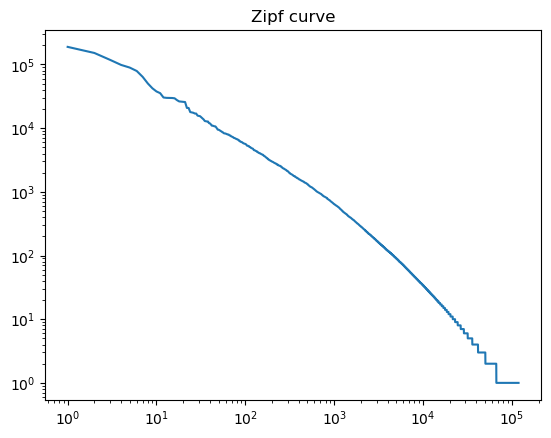

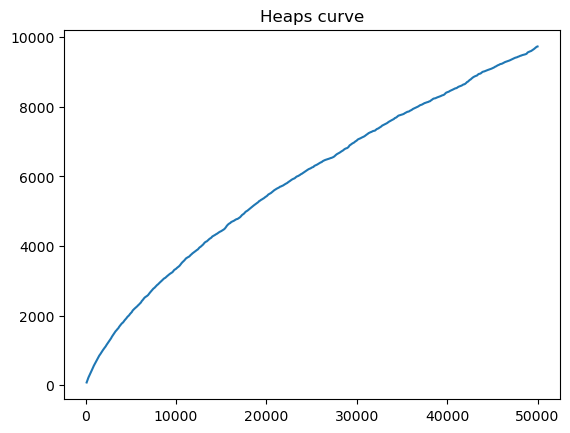

In [7]:
import numpy as np

# Zipf
freqs = np.array(sorted(cnt.values(), reverse=True))
plt.loglog(range(1, len(freqs)+1), freqs)
plt.title("Zipf curve")
plt.show()

# Heaps
seen = set()
vocab_sizes = []
tokens_seen = 0
for tok in all_tokens[:50000]:
    tokens_seen += 1
    seen.add(tok)
    if tokens_seen % 100 == 0:
        vocab_sizes.append((tokens_seen, len(seen)))
xs, ys = zip(*vocab_sizes)
plt.plot(xs, ys)
plt.title("Heaps curve")
plt.show()

## Сравнение слов и TF-IDF

In [8]:
print("'сотрудник' vs 'клиент':", cnt['сотрудник'], cnt['клиент'])
print("'мошенничество':", cnt['мошенничество'])
print("'доверие':", cnt['доверие'])

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), token_pattern=r"\w+")
X = tfidf.fit_transform(df['text'].fillna(''))
feat_names = tfidf.get_feature_names_out()

def top_tfidf(class_val):
    idx = df[df['rating']==class_val].index
    sub = X[idx]
    mean_tfidf = sub.mean(axis=0).A1
    top_idx = mean_tfidf.argsort()[::-1][:15]
    return [feat_names[i] for i in top_idx]

print("Top TF-IDF (5):", top_tfidf(5))
print("Top TF-IDF (1):", top_tfidf(1))

'сотрудник' vs 'клиент': 3406 3214
'мошенничество': 107
'доверие': 166
Top TF-IDF (5): ['в', 'и', 'на', 'не', 'что', 'я', 'с', 'очень', 'все', 'по', 'банка', 'за', 'мне', 'как', 'банк']
Top TF-IDF (1): ['в', 'и', 'не', 'на', 'что', 'я', 'с', 'мне', 'по', 'банка', 'а', 'банк', 'то', 'как', 'за']


## 2. Тематическое моделирование (LDA)

In [9]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_df=0.95, min_df=5, token_pattern=r"\w+")
Xc = cv.fit_transform(df['text'].fillna('').sample(5000, random_state=0))

lda = LatentDirichletAllocation(n_components=10, random_state=0, max_iter=10)
lda.fit(Xc)
feature_names = cv.get_feature_names_out()
for t, comp in enumerate(lda.components_):
    top = comp.argsort()[::-1][:10]
    print("Topic", t, ":", [feature_names[i] for i in top])

Topic 0 : ['на', 'не', 'с', 'по', 'банка', 'что', 'я', 'к', 'банк', 'за']
Topic 1 : ['не', 'что', 'я', 'на', 'с', 'то', 'но', 'как', 'а', 'все']
Topic 2 : ['я', 'втб', 'по', 'что', '24', 'на', 'с', 'не', 'за', 'банка']
Topic 3 : ['не', 'на', 'я', 'что', 'с', 'карты', 'карту', 'мне', 'по', 'за']
Topic 4 : ['на', 'что', 'не', 'по', 'мне', 'с', 'я', 'банка', 'дней', 'заявление']
Topic 5 : ['с', 'банка', 'все', 'учиться', 'не', 'быстро', 'реструктуризации', 'банке', 'спасибо', 'аижк']
Topic 6 : ['не', 'что', 'на', 'я', 'деньги', 'а', 'с', 'мне', 'то', 'у']
Topic 7 : ['на', 'по', 'с', 'не', 'банка', 'вклада', 'вклад', 'при', '1', 'банк']
Topic 8 : ['не', 'что', 'я', 'по', 'с', 'банка', 'банк', 'на', 'о', 'меня']
Topic 9 : ['я', 'не', 'что', 'на', 'мне', 'кредит', 'с', 'по', 'а', 'все']


## 3. Классификация 1 vs 5

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

df_bin = df[df['rating'].isin([1,5])]
X_texts = df_bin['text'].fillna('')
y = (df_bin['rating']==5).astype(int)

tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=20000, token_pattern=r"\w+")
X = tfidf.fit_transform(X_texts)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))

Accuracy: 0.9543707973102786
F1: 0.9270913277052955
